# Title: Implement the Continuous Bag of Words (CBOW) Model.

Aim: Implement the Continuous Bag of Words (CBOW) Model.
Stages can be:
a)Data preparation
b)Generate training data
c)Train model
d)Output

an "epoch" is a term used to describe a complete pass through your entire training dataset during the training of a neural network.

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns #used for creating informative and attractive statistical graphics
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np #NumPy is a Python library used for numerical computations and working with arrays and matrices, making it essential for scientific computing and data analysis.
%matplotlib inline

In [3]:
#Data Prepration
import re

In [4]:
sentences = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

a)Data preparation
Clean Data

In [5]:
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

b)Generate training data
Vocabulary

In [6]:
words = sentences.split()
vocab = set(words)  # set is a data structure that contains unique elements

In [8]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2

Implementation 

In [9]:
word_to_ix = {word: i for i, word in enumerate(vocab)}# This dictionary maps words to their respective indices
ix_to_word = {i: word for i, word in enumerate(vocab)}#It maps numerical indices to their corresponding words

Data bags

In [14]:
# data - [(context), target]

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
#result is a list of context-target pairs
print(data[:5])

[(['we', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'computational'], 'idea')]


Embeddings

In [15]:
embeddings =  np.random.random_sample((vocab_size, embed_dim))   #  This is a NumPy array that will store the word embeddings  
#embed_dim is the dimensionality of each word embedding vector.
#vocab_size is the number of unique words in your vocabulary

Linear Model

In [25]:
def linear(m, theta):
    w = theta
    return m.dot(w) # calculates the dot product between the m and w vectors

Log softmax + NLLloss = Cross Entropy

In [16]:
def log_softmax(x):   #The log-softmax is often used in machine learning for tasks like classification
    e_x = np.exp(x - np.max(x)) # calculates the exponential of each element in the input vector x
    return np.log(e_x / e_x.sum()) #function computes the log of the softmax values

In [17]:
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]  #selects the log probabilities corresponding to the correct classes for each example.
    return -out.sum()/len(out)  #the function returns the negative of the sum of log probabilities divided by the number of examples. This is a common way to compute the average negative log-likelihood loss across a batch of examples.

In [18]:
#The function essentially calculates the cross-entropy loss between the predicted log-softmax values (logits) and the true one-hot encoded target values. This loss is often used as a measure of the dissimilarity between predicted and actual class probabilities in classification tasks.
def log_softmax_crossentropy_with_logits(logits,target):
    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    return (- out + softmax) / logits.shape[0]

Forward function

In [19]:
def forward(context_idxs, theta):  #represent a forward pass in a simple neural network #theta-weight vector 
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    return m, n, o

Backward function

In [21]:
# represent the backward pass or gradient computation step in a neural network
def backward(preds, theta, target_idxs):
    m, n, o = preds
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)
    return dw

Optimize function

In [22]:
#represent an optimization step where the model parameters (in this case, theta) are updated based on the computed gradients (grad) using a specified learning rate (lr
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr  #lr - means learning rate
    return theta

Training 

In [23]:
#Genrate training data
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))
#this line essentially initializes your model parameters (in this case, theta) with random values within the specified range. These random initial values are often used as a starting point before training the model, where they will be updated during the training process using techniques like gradient descent

In [27]:
epoch_losses = {}
#be training the model using some form of stochastic gradient descent
for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context]) #created by converting the context words to their corresponding indices 
        preds = forward(context_idxs, theta)#obtained by running a forward pass with the context indices and the theta 

        target_idxs = np.array([word_to_ix[target]])# created by converting the target word to its corresponding index
        loss = NLLLoss(preds[-1], target_idxs) #calculated using the negative log-likelihood loss (NLLLoss) based on the predictions and the true target index

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)  #The model parameters (represented by theta) are updated using the optimize 
        
     
    epoch_losses[epoch] = losses # loss values for each epoch are stored in the epoch_losses dictionary

Analyze 

Plot loss/epoch

Text(0, 0.5, 'Losses')

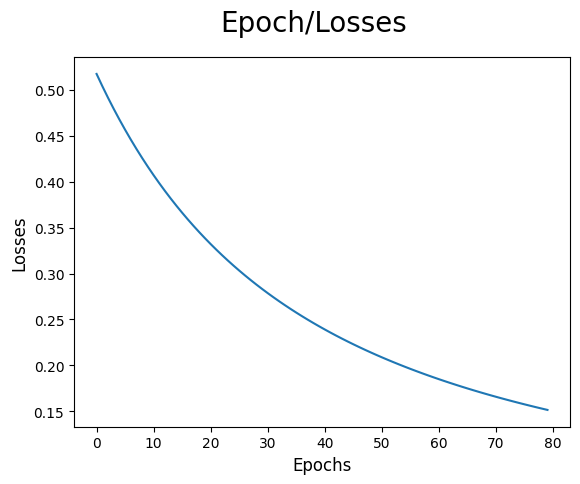

In [28]:
ix = np.arange(0,80)  #using NumPy to create an array ix that represents the x-axis values. It spans from 0 to 79, which will be used for the epochs.

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix]) #plots line
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

Predict function

In [29]:
def predict(words): #related to word predictio
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    
    return word

In [31]:
# (['we', 'are', 'to', 'study'], 'about')
predict(['we', 'are', 'to', 'study'])  #should return the word that the model predicts is most likely to follow the input sequence.

'about'

Accuracy

In [32]:
def accuracy(): #to calculate the accuracy of a language model
    wrong = 0
    for context, target in data:
        if(predict(context) != target):
            wrong += 1            
    return (1 - (wrong / len(data)))

In [33]:
accuracy()

1.0

In [34]:
predict(['processes', 'manipulate', 'things', 'study'])

'abstract'